# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm
import os


from collections import Counter

## Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv',nrows=70000)
resource_data = pd.read_csv('resources.csv')

In [3]:
project_data.isnull().sum()

Unnamed: 0                                          0
id                                                  0
teacher_id                                          0
teacher_prefix                                      3
school_state                                        0
project_submitted_datetime                          0
project_grade_category                              0
project_subject_categories                          0
project_subject_subcategories                       0
project_title                                       0
project_essay_1                                     0
project_essay_2                                     0
project_essay_3                                 67612
project_essay_4                                 67612
project_resource_summary                            0
teacher_number_of_previously_posted_projects        0
project_is_approved                                 0
dtype: int64

In [4]:
project_data.dropna(subset = ['teacher_prefix'], inplace=True)

In [5]:
project_data.isnull().sum()

Unnamed: 0                                          0
id                                                  0
teacher_id                                          0
teacher_prefix                                      0
school_state                                        0
project_submitted_datetime                          0
project_grade_category                              0
project_subject_categories                          0
project_subject_subcategories                       0
project_title                                       0
project_essay_1                                     0
project_essay_2                                     0
project_essay_3                                 67610
project_essay_4                                 67610
project_resource_summary                            0
teacher_number_of_previously_posted_projects        0
project_is_approved                                 0
dtype: int64

In [6]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)

In [7]:
print("Number of data points in entire data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in entire data (69997, 16)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects']


In [8]:
print("Number of data points in entire data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in entire data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


## Preprocessing of `project_subject_categories`

In [9]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

##  Preprocessing of `project_subject_subcategories`

In [10]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

##  Text preprocessing

In [11]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [12]:
# Dropping the other 4 columns related in project essay
project_data.drop(['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4'], axis=1, inplace=True)

In [13]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,Literacy_Language,ESL Literacy,My students are English learners that are work...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,My students need a projector to help with view...,7,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...


In [14]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[29500])
print("="*50)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

My students are an amazing group of eclectic children, coming from all walks of life. Many are from socioeconomically challenged homes, many from migrant families. The city is small so that most students who are permanent residents have known each other forever. It is a 'large family' of sorts. They all support each other and strive everyday to be successful. And they are! \r\nAs second language learners, many struggle day to day to learn in the classroom but excel in physical activity!Most students think of exercise during the day as their recess time. By teaching them how to purposefully exercise, how to keep track of their exercise, as well as hypothesize results, students will create a lifelong love of exercise and health. My students told me how much they enjoy Physical Education outdoors. They have asked for field cones and activities such as fitness dice and foam rings to organize meaningful activities. These journals will be used to chart patterns and see growth. My students sh

In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"%", " percent", phrase)
    phrase = re.sub("nannan",' ', phrase)# Found this pattern in some essays which adds no meaning
    return phrase

In [16]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My wonderful students are 3, 4, and 5 years old.  We are located in a small town outside of Charlotte, NC.  All of my 22 students are children of school district employees.\r\nMy students are bright, energetic, and they love to learn!  They love hands-on activities that get them moving.  Like most preschoolers, they enjoy music and creating different things. \r\nAll of my students come from wonderful families that are very supportive of our classroom.  Our parents enjoy watching their children is growth as much as we do!These materials will help me teach my students all about the life cycle of a butterfly.  We will watch as the Painted Lady caterpillars grow bigger and build their chrysalis.  After a few weeks they will emerge from the chrysalis as beautiful butterflies!  We already have a net for the chrysalises, but we still need the caterpillars and feeding station.\r\nThis will be an unforgettable experience for my students.  My student absolutely love hands-on materials.  They lea

In [17]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My wonderful students are 3, 4, and 5 years old.  We are located in a small town outside of Charlotte, NC.  All of my 22 students are children of school district employees.  My students are bright, energetic, and they love to learn!  They love hands-on activities that get them moving.  Like most preschoolers, they enjoy music and creating different things.   All of my students come from wonderful families that are very supportive of our classroom.  Our parents enjoy watching their children is growth as much as we do!These materials will help me teach my students all about the life cycle of a butterfly.  We will watch as the Painted Lady caterpillars grow bigger and build their chrysalis.  After a few weeks they will emerge from the chrysalis as beautiful butterflies!  We already have a net for the chrysalises, but we still need the caterpillars and feeding station.  This will be an unforgettable experience for my students.  My student absolutely love hands-on materials.  They learn so 

In [18]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My wonderful students are 3 4 and 5 years old We are located in a small town outside of Charlotte NC All of my 22 students are children of school district employees My students are bright energetic and they love to learn They love hands on activities that get them moving Like most preschoolers they enjoy music and creating different things All of my students come from wonderful families that are very supportive of our classroom Our parents enjoy watching their children is growth as much as we do These materials will help me teach my students all about the life cycle of a butterfly We will watch as the Painted Lady caterpillars grow bigger and build their chrysalis After a few weeks they will emerge from the chrysalis as beautiful butterflies We already have a net for the chrysalises but we still need the caterpillars and feeding station This will be an unforgettable experience for my students My student absolutely love hands on materials They learn so much from getting to touch and man

In [19]:
project_data.shape

(69997, 13)

In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [21]:
# Combining all the above snippets 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 69997/69997 [00:57<00:00, 1216.99it/s]


In [22]:
# after preprocesing
preprocessed_essays[20000]

'wonderful students 3 4 5 years old located small town outside charlotte nc 22 students children school district employees students bright energetic love learn love hands activities get moving like preschoolers enjoy music creating different things students come wonderful families supportive classroom parents enjoy watching children growth much materials help teach students life cycle butterfly watch painted lady caterpillars grow bigger build chrysalis weeks emerge chrysalis beautiful butterflies already net chrysalises still need caterpillars feeding station unforgettable experience students student absolutely love hands materials learn much getting touch manipulate different things supporting materials selected help students understand life cycle exploration'

<h2><font color='black'>  Preprocessing of `project_title`</font></h2>

In [23]:
# similarly preprocessing the titles also
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 69997/69997 [00:02<00:00, 26703.09it/s]


In [24]:
project_data['project_title'] = preprocessed_title

In [25]:
#Removing '.' from teacher prefix(as a process of text preprocessing)
project_data['teacher_prefix']=project_data['teacher_prefix'].str.replace('\.','',regex=True).astype(str)

In [26]:
project_data['teacher_prefix'].isna().any()

False

In [27]:
project_data['teacher_prefix'].value_counts()

Mrs        36529
Ms         25150
Mr          6828
Teacher     1485
Dr             5
Name: teacher_prefix, dtype: int64

In [28]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [29]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [30]:
project_data['price'].isnull().any()

False

In [31]:
#Removing '-' from teacher prefix(as a process of text preprocessing)
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('\s+', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-', '_')

In [32]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
m = []
def senti(i):
    l = []
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(i)
    for k in ss:
        l.append(ss[k])
    return l

In [33]:
project_data['text'] = pd.DataFrame(preprocessed_essays)

In [34]:
# Googled for this
import swifter
df2 = project_data['text'].swifter.apply(lambda x : senti(x))

In [35]:
senti_score_essay = pd.DataFrame(df2.values.tolist(), columns=['neg','neu','pos','compound'])

In [36]:
#https://stackoverflow.com/questions/23891575/how-to-merge-two-dataframes-side-by-side
project_data = pd.concat([project_data, senti_score_essay], axis=1)

In [38]:
#https://stackoverflow.com/questions/34962104/pandas-how-can-i-use-the-apply-function-for-a-single-column
a=project_data['project_title'].apply(lambda x : len(x))

In [39]:
project_data['now_title'] = pd.DataFrame(a)

In [40]:
#https://stackoverflow.com/questions/34962104/pandas-how-can-i-use-the-apply-function-for-a-single-column
b=project_data['text'].apply(lambda x : len(x))

In [41]:
project_data['now_text'] = pd.DataFrame(b)

##  Preparing data for models

In [42]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'quantity', 'text', 'neg',
       'neu', 'pos', 'compound', 'now_title', 'now_text'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optional)
       
       - quantity : numerical (optional)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [43]:
final_features = ['school_state', 'clean_categories', 'clean_subcategories', 'text', 'project_grade_category', 'teacher_prefix', 'project_title', 'teacher_number_of_previously_posted_projects', 'price','quantity','now_title','now_text','neg','neu','pos','compound']

In [44]:
project_data1 = project_data[final_features].copy()

In [45]:
project_data1.columns

Index(['school_state', 'clean_categories', 'clean_subcategories', 'text',
       'project_grade_category', 'teacher_prefix', 'project_title',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'now_title', 'now_text', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

In [46]:
X = project_data1.copy()

In [47]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,test_size=0.33,stratify=y_train, random_state=42)

In [48]:
print("Shape of X_train",X_train.shape)
print("Shape of y_train",y_train.shape)
print('\n')
print("Shape of X_cv",X_cv.shape)
print("Shape of y_cv",y_cv.shape)
print('\n')
print("Shape of X_test",X_test.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train (31420, 16)
Shape of y_train (31420,)


Shape of X_cv (15477, 16)
Shape of y_cv (15477,)


Shape of X_test (23100, 16)
Shape of y_test (23100,)


###  Vectorizing Categorical data

<h3> Encoding categorical features: school_state</h3>

In [49]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31420, 51) (31420,)
(15477, 51) (15477,)
(23100, 51) (23100,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3> Encoding categorical features: teacher_prefix</h3>

In [50]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values.astype(str))

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31420, 5) (31420,)
(15477, 5) (15477,)
(23100, 5) (23100,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


<h3> Encoding categorical features: project_grade_category</h3>

In [51]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31420, 4) (31420,)
(15477, 4) (15477,)
(23100, 4) (23100,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h3> Encoding categorical features: clean_subcategories</h3>

In [52]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcat_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcat_ohe.shape, y_train.shape)
print(X_cv_subcat_ohe.shape, y_cv.shape)
print(X_test_subcat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31420, 30) (31420,)
(15477, 30) (15477,)
(23100, 30) (23100,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


<h3> Encoding categorical features: clean_categories</h3>

In [53]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_cat_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_cat_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_cat_ohe.shape, y_train.shape)
print(X_cv_cat_ohe.shape, y_cv.shape)
print(X_test_cat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31420, 9) (31420,)
(15477, 9) (15477,)
(23100, 9) (23100,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


<h3>Encoding numerical features: Price</h3>

In [54]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm = X_train_price_norm.reshape(-1,1)
X_cv_price_norm = X_cv_price_norm.reshape(-1,1)
X_test_price_norm = X_test_price_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(31420, 1) (31420,)
(15477, 1) (15477,)
(23100, 1) (23100,)


<h3>Encoding numerical features: Quantity</h3>

In [55]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_quan_norm = normalizer.transform(X_train['quantity'].values.reshape(1,-1))
X_cv_quan_norm = normalizer.transform(X_cv['quantity'].values.reshape(1,-1))
X_test_quan_norm = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

X_train_quan_norm = X_train_quan_norm.reshape(-1,1)
X_cv_quan_norm = X_cv_quan_norm.reshape(-1,1)
X_test_quan_norm = X_test_quan_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_quan_norm.shape, y_train.shape)
print(X_cv_quan_norm.shape, y_cv.shape)
print(X_test_quan_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(31420, 1) (31420,)
(15477, 1) (15477,)
(23100, 1) (23100,)


In [56]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['now_title'].values.reshape(1,-1))

X_train_now_title_norm = normalizer.transform(X_train['now_title'].values.reshape(1,-1))
X_cv_now_title_norm = normalizer.transform(X_cv['now_title'].values.reshape(1,-1))
X_test_now_title_norm = normalizer.transform(X_test['now_title'].values.reshape(1,-1))

X_train_now_title_norm = X_train_now_title_norm.reshape(-1,1)
X_cv_now_title_norm = X_cv_now_title_norm.reshape(-1,1)
X_test_now_title_norm = X_test_now_title_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_now_title_norm.shape, y_train.shape)
print(X_cv_now_title_norm.shape, y_cv.shape)
print(X_test_now_title_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(31420, 1) (31420,)
(15477, 1) (15477,)
(23100, 1) (23100,)


In [57]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['now_text'].values.reshape(1,-1))

X_train_now_text_norm = normalizer.transform(X_train['now_text'].values.reshape(1,-1))
X_cv_now_text_norm = normalizer.transform(X_cv['now_text'].values.reshape(1,-1))
X_test_now_text_norm = normalizer.transform(X_test['now_text'].values.reshape(1,-1))

X_train_now_text_norm = X_train_now_text_norm.reshape(-1,1)
X_cv_now_text_norm = X_cv_now_text_norm.reshape(-1,1)
X_test_now_text_norm = X_test_now_text_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_now_text_norm.shape, y_train.shape)
print(X_cv_now_text_norm.shape, y_cv.shape)
print(X_test_now_text_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(31420, 1) (31420,)
(15477, 1) (15477,)
(23100, 1) (23100,)


In [58]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['neg'].values.reshape(1,-1))

X_train_neg_norm = normalizer.transform(X_train['neg'].values.reshape(1,-1))
X_cv_neg_norm = normalizer.transform(X_cv['neg'].values.reshape(1,-1))
X_test_neg_norm = normalizer.transform(X_test['neg'].values.reshape(1,-1))

X_train_neg_norm = X_train_neg_norm.reshape(-1,1)
X_cv_neg_norm = X_cv_neg_norm.reshape(-1,1)
X_test_neg_norm = X_test_neg_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)
print(X_test_neg_norm.shape, y_cv.shape)
print(X_cv_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(31420, 1) (31420,)
(23100, 1) (15477,)
(15477, 1) (23100,)


In [59]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['pos'].values.reshape(1,-1))

X_train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(1,-1))
X_cv_pos_norm = normalizer.transform(X_cv['pos'].values.reshape(1,-1))
X_test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(1,-1))

X_train_pos_norm = X_train_pos_norm.reshape(-1,1)
X_cv_pos_norm = X_cv_pos_norm.reshape(-1,1)
X_test_pos_norm = X_test_pos_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_pos_norm.shape, y_train.shape)
print(X_test_pos_norm.shape, y_cv.shape)
print(X_cv_pos_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(31420, 1) (31420,)
(23100, 1) (15477,)
(15477, 1) (23100,)


In [60]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['neg'].values.reshape(1,-1))

X_train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(1,-1))
X_cv_neu_norm = normalizer.transform(X_cv['neu'].values.reshape(1,-1))
X_test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(1,-1))

X_train_neu_norm = X_train_neu_norm.reshape(-1,1)
X_cv_neu_norm = X_cv_neu_norm.reshape(-1,1)
X_test_neu_norm = X_test_neu_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_neu_norm.shape, y_train.shape)
print(X_cv_neu_norm.shape, y_cv.shape)
print(X_test_neu_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(31420, 1) (31420,)
(15477, 1) (15477,)
(23100, 1) (23100,)


In [61]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['compound'].values.reshape(1,-1))

X_train_com_norm = normalizer.transform(X_train['compound'].values.reshape(1,-1))
X_cv_com_norm = normalizer.transform(X_cv['compound'].values.reshape(1,-1))
X_test_com_norm = normalizer.transform(X_test['compound'].values.reshape(1,-1))

X_train_com_norm = X_train_com_norm.reshape(-1,1)
X_cv_com_norm = X_cv_com_norm.reshape(-1,1)
X_test_com_norm = X_test_com_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_com_norm.shape, y_train.shape)
print(X_test_com_norm.shape, y_cv.shape)
print(X_cv_com_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(31420, 1) (31420,)
(23100, 1) (15477,)
(15477, 1) (23100,)


<h3>Encoding numerical features: teacher_number_of_projects</h3>

In [62]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_number_of_previously_posted_projects_norm = X_train_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)
X_cv_teacher_number_of_previously_posted_projects_norm = X_cv_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)
X_test_teacher_number_of_previously_posted_projects_norm = X_test_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_cv_teacher_number_of_previously_posted_projects_norm.shape, y_cv.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(31420, 1) (31420,)
(15477, 1) (15477,)
(23100, 1) (23100,)


### Vectorizing Text data

###  Bag of words

In [63]:
vectorizer = CountVectorizer(min_df=10, ngram_range=(2,3), max_features = 5000)
vectorizer.fit(X_train['text'].values) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_text_bow = vectorizer.transform(X_train['text'].values)
X_cv_text_bow = vectorizer.transform(X_cv['text'].values)
X_test_text_bow = vectorizer.transform(X_test['text'].values)

print("After vectorizations")
print(X_train_text_bow.shape, y_train.shape)
print(X_cv_text_bow.shape, y_cv.shape)
print(X_test_text_bow.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31420, 5000) (31420,)
(15477, 5000) (15477,)
(23100, 5000) (23100,)


['000 students', '10 percent', '10 years', '100 percent', '100 percent free', '100 percent students', '100 students', '12th grade', '1st grade', '1st graders', '20 minutes', '20 percent', '20 students', '2016 2017', '2016 2017 school', '2017 school', '2017 school year', '21st century', '21st century classroom', '21st century learners', '21st century learning', '21st century skills', '22 students', '24 students', '25 percent', '25 students', '2nd grade', '2nd grade students', '2nd graders', '30 minutes', '30 percent', '30 students', '300 students', '3d printer', '3d printing', '3rd 4th', '3rd grade', '3rd grade students', '3rd graders', '40 percent', '40 percent students', '400 students', '4th 5th', '4th 5th grade', '4th grade', '4th grade students', '4th graders', '50 percent', '50 percent students', '500 students', '5th 6th', '5th grade', '5th grade students', '5th graders', '60 minutes', '60 minutes day', '60 percent', '60 percent students', '600 students', '65 percent', '6th 7th', '

In [64]:
vectorizer = CountVectorizer(min_df = 5, ngram_range=(2,2), max_features=5000)
vectorizer.fit(X_train['project_title'].values.astype('U')) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector

X_train_title_bow = vectorizer.transform(X_train['project_title'].values.astype('U'))
X_cv_title_bow = vectorizer.transform(X_cv['project_title'].values.astype('U'))
X_test_title_bow = vectorizer.transform(X_test['project_title'].values.astype('U'))

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31420, 2576) (31420,)
(15477, 2576) (15477,)
(23100, 2576) (23100,)


['03 16', '05 03', '1st grade', '1st graders', '2016 2017', '21st century', '2nd grade', '2nd graders', '3d pens', '3d printer', '3d printing', '3rd grade', '3rd graders', '4th grade', '4th graders', '5th grade', '5th graders', '60 minutes', '6th grade', '7th grade', '7th graders', '8th grade', 'abc 123', 'about art', 'about it', 'about learning', 'about money', 'about our', 'about reading', 'about science', 'about that', 'about the', 'academic success', 'access technology', 'accessible all', 'achievement gap', 'active bodies', 'active brains', 'active classroom', 'active engagement', 'active healthy', 'active kids', 'active learners', 'active learning', 'active minds', 'active play', 'active recess', 'active seating', 'active students', 'active with', 'adventures reading', 'after flood', 'after school', 'ahead with', 'ai not', 'alive through', 'alive with', 'all aboard', 'all about', 'all around', 'all day', 'all ears', 'all hands', 'all kids', 'all learners', 'all readers', 'all stud

####  TFIDF vectorizer

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['text'].values) # fit has to happen only on train data

# we use the fitted tfidfVectorizer to convert the text to vector
X_train_text_tfidf = vectorizer.transform(X_train['text'].values)
X_cv_text_tfidf = vectorizer.transform(X_cv['text'].values)
X_test_text_tfidf = vectorizer.transform(X_test['text'].values)

print("After vectorizations")
print(X_train_text_tfidf.shape, y_train.shape)
print(X_cv_text_tfidf.shape, y_cv.shape)
print(X_test_text_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31420, 10081) (31420,)
(15477, 10081) (15477,)
(23100, 10081) (23100,)


['00', '000', '10', '100', '1000', '101', '103', '10th', '11', '110', '1100', '11th', '12', '120', '1200', '125', '12th', '13', '130', '1300', '14', '140', '1400', '15', '150', '1500', '15th', '16', '160', '1600', '17', '170', '18', '180', '1800', '19', '1st', '20', '200', '2000', '2003', '2004', '2005', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '20th', '21', '21st', '22', '23', '24', '25', '250', '26', '27', '270', '28', '280', '29', '2d', '2nd', '30', '300', '3000', '31', '32', '320', '33', '34', '35', '350', '36', '360', '365', '37', '38', '39', '3d', '3doodler', '3doodlers', '3rd', '40', '400', '41', '42', '43', '44', '45', '450', '46', '47', '48', '480', '49', '4k', '4th', '50', '500', '504', '51', '52', '53', '54', '55', '550', '56', '560', '57', '58', '59', '5k', '5th', '60', '600', '61', '62', '63', '64', '65', '650', '66', '67', '68', '69', '6th', '70', '700', '71', '72', '73', '74', '75', '750', '76', '77', '78', '79', '7t

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['project_title'].values.astype('U')) # fit has to happen only on train data

# we use the fitted tfidfVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['project_title'].values.astype('U'))
X_cv_title_tfidf = vectorizer.transform(X_cv['project_title'].values.astype('U'))
X_test_title_tfidf = vectorizer.transform(X_test['project_title'].values.astype('U'))

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31420, 1577) (31420,)
(15477, 1577) (15477,)
(23100, 1577) (23100,)


['05', '10', '101', '16', '1st', '2016', '2017', '21st', '2nd', '3d', '3doodler', '3rd', '4th', '5th', '60', '6th', '7th', '8th', 'abc', 'aboard', 'about', 'academic', 'access', 'accessible', 'accessing', 'accessories', 'achieve', 'achievement', 'across', 'act', 'action', 'active', 'actively', 'activities', 'activity', 'add', 'adding', 'advanced', 'adventure', 'adventures', 'after', 'again', 'age', 'ahead', 'air', 'algebra', 'alive', 'all', 'along', 'aloud', 'alouds', 'alphabet', 'alternative', 'always', 'am', 'amazing', 'amazon', 'america', 'american', 'an', 'anchor', 'ancient', 'and', 'animal', 'another', 'ants', 'anything', 'anywhere', 'ap', 'app', 'apple', 'apples', 'approach', 'apps', 'architects', 'are', 'area', 'around', 'art', 'artist', 'artistic', 'artists', 'arts', 'as', 'aspiring', 'at', 'athletes', 'atpe', 'attention', 'audio', 'author', 'authors', 'autism', 'avid', 'award', 'awareness', 'away', 'awesome', 'baby', 'back', 'backpack', 'backpacks', 'bag', 'bags', 'balance', '

### Using gensim for doing word2vec

### Applying word2vec on project title

In [67]:
list_of_sentance_train=[]
for sentance in (X_train['project_title'].values):
    list_of_sentance_train.append(sentance.split())
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

C:\Users\mani\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


number of words that occured minimum 5 times  2612
sample words  ['uke', 'n', 'do', 'it', 'a', 'printer', 'ink', 'please', 'keep', 'moving', 'flexible', 'seating', 'engaged', 'learners', 'technology', 'in', 'my', 'hand', 'history', 'literature', 'promote', 'walking', '4th', 'graders', 'create', 'collaborate', 'chromebooks', 'part', '16', '17', 'portable', 'magic', 'kindle', 'fires', 'we', 'got', 'the', 'write', 'stuff', 'colorful', 'mindset', 'cozy', 'up', 'read', 'science', 'exploration', 'creating', 'positive', 'school', 'culture']


In [68]:
from tqdm import tqdm
import numpy as np
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
X_train_title_avgw2v = np.array(sent_vectors_train)
print(X_train_title_avgw2v.shape)
print(X_train_title_avgw2v[0])

100%|█████████████████████████████████████████████████████████████████████████| 31420/31420 [00:02<00:00, 10650.79it/s]


(31420, 50)
[-5.08816745e-02  1.45154527e-01  3.56130388e-01 -1.03055507e+00
  6.97106495e-03  6.39888983e-01  3.40124920e-01 -3.67200351e-03
 -5.18271670e-01 -4.07143432e-01 -5.24845172e-01  4.94243111e-02
  2.68066887e-01 -2.61641080e-01 -6.41805194e-02  3.33234136e-01
  6.95195869e-01  1.85921886e-01 -1.92988122e-01 -5.91347188e-01
  6.32075202e-02 -1.19326448e+00  4.92527032e-01  5.38565852e-01
  1.64447869e-01 -8.38620793e-01 -6.04664123e-01  6.13397004e-01
  2.88028029e-01  3.09706559e-01  4.39725508e-01 -2.70378822e-02
  3.25252302e-04 -1.61965269e-01  4.34887245e-01  1.59882893e-01
 -4.13327608e-01  9.91029246e-02 -6.04767960e-01 -3.30887170e-01
 -2.71422556e-02 -6.98236357e-02 -9.69100385e-02 -4.27630052e-01
 -7.85200978e-02  4.02326251e-02  4.28771041e-02  2.93610421e-01
  1.40351940e-01 -5.09939827e-02]


In [69]:
list_of_sentance_train=[]
for sentance in (X_cv['project_title'].values):
    list_of_sentance_train.append(sentance.split())
from tqdm import tqdm
import numpy as np
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
X_cv_title_avgw2v = np.array(sent_vectors_train)
print(X_cv_title_avgw2v.shape)
print(X_cv_title_avgw2v[0])

100%|█████████████████████████████████████████████████████████████████████████| 15477/15477 [00:01<00:00, 11256.45it/s]


(15477, 50)
[ 3.67703132e-01  5.10731577e-01  1.85832135e-01 -9.63744126e-01
 -3.74046497e-01  7.65606057e-01  6.80749662e-01  1.01115555e-03
 -6.54787532e-01 -2.34114075e-01 -6.04289506e-01 -2.11643644e-01
 -9.44414334e-02 -2.05941750e-01  8.96879062e-02  2.90581442e-01
  7.58801520e-01 -2.18413138e-02 -1.99453676e-01 -2.63970993e-01
 -2.14429351e-01 -1.42165713e+00  5.11424735e-01  9.68710959e-01
  1.69018681e-01 -5.17017230e-01  2.05646504e-01  2.40451606e-01
  4.26270034e-01  6.41157255e-02 -9.20658391e-02 -2.93228306e-01
 -3.60374809e-01 -2.29646552e-01  2.75285462e-01  3.31047680e-01
 -1.04467613e+00 -1.89409804e-01 -3.31501551e-01  4.18751065e-01
 -2.00909747e-01  1.04930915e-01 -3.42336707e-02 -3.26252565e-01
 -1.40244059e-01 -2.97310825e-01  1.34530306e-01  4.14027862e-01
  1.56419855e-01 -1.22554693e-01]


In [70]:
list_of_sentance_train=[]
for sentance in (X_test['project_title'].values):
    list_of_sentance_train.append(sentance.split())
from tqdm import tqdm
import numpy as np
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
X_test_title_avgw2v = np.array(sent_vectors_train)
print(X_test_title_avgw2v.shape)
print(X_test_title_avgw2v[0])

100%|█████████████████████████████████████████████████████████████████████████| 23100/23100 [00:02<00:00, 11070.52it/s]


(23100, 50)
[ 1.60020858e-01  5.76510712e-02  4.34399708e-01 -5.62790441e-01
 -3.53790683e-01  3.64384854e-01  2.63641582e-01 -1.91898116e-01
 -4.72982532e-02 -1.05507281e-01 -2.56424318e-01  2.95911440e-01
  6.56699887e-02 -2.03353104e-01  2.32223336e-01  1.46446767e-01
  4.96448817e-01  4.43469610e-02  9.91963052e-02 -4.52972279e-01
  1.37884803e-01 -7.76379051e-01  1.85170905e-01  6.26554452e-01
 -2.79808204e-03 -5.32119550e-01 -2.68106870e-01  1.62136688e-01
  1.92824632e-02  2.93994902e-01  1.54862713e-01 -7.87406680e-02
  6.56865925e-04 -4.58303098e-02  1.56320330e-01  2.81844499e-01
 -5.47707578e-01 -6.62067103e-02 -5.33916799e-01  1.38407283e-01
  4.68855975e-02 -2.47927590e-01  5.79056855e-02 -3.63613057e-01
  1.40693124e-01  1.85042507e-02  2.59669105e-01 -3.41643634e-02
 -1.93844660e-01  5.40444668e-02]


### Applying avg word2vec on project_essay

In [71]:
list_of_sentance_train_essay=[]
for sentance in (X_train['text'].values):
    list_of_sentance_train_essay.append(sentance.split())
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2v_model1=Word2Vec(list_of_sentance_train_essay,min_count=5,size=50, workers=4)
w2v_words1 = list(w2v_model1.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words1))
print("sample words ", w2v_words1[0:50])

number of words that occured minimum 5 times  14319
sample words  ['general', 'music', 'program', 'prides', 'diversified', 'meet', 'needs', 'student', 'population', 'students', 'always', 'strive', 'making', 'lesson', 'truly', 'artful', 'joyful', 'experience', 'every', 'day', 'make', 'learning', 'target', 'goals', 'aim', 'achieve', 'excellence', 'behavior', 'academics', 'community', 'heavily', 'supports', 'physical', 'presence', 'low', 'socioeconomically', 'ability', 'purchase', 'classroom', 'materials', 'sometimes', 'challenge', 'child', 'deserves', 'quality', 'education', 'instance', 'project', 'help', 'us']


In [72]:
from tqdm import tqdm
import numpy as np
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train_essay): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
X_train_text_avgw2v = np.array(sent_vectors_train)
print(X_train_text_avgw2v.shape)
print(X_train_text_avgw2v[0])

100%|███████████████████████████████████████████████████████████████████████████| 31420/31420 [02:28<00:00, 211.47it/s]


(31420, 50)
[ 0.16773694  0.5519373  -0.27245526  0.10899999  0.02049001 -0.41106746
  0.15320979  0.20633077  0.23867219  0.24645881  0.20712612 -0.28103144
  0.20935603 -0.16107841 -0.41510981  0.1040164  -0.11247526 -0.19122567
  0.63370098 -0.00148285  0.55683751  0.34380824 -0.66137135 -0.55333744
  0.45918834 -1.07003462  0.61452636 -0.45047458 -0.21282746  0.2842797
 -0.50638323  0.17299777 -0.16235106  0.55577988 -0.12084827 -1.11540053
 -0.45256541 -0.35865587  0.80633763  0.19526129 -0.17205287  0.50529664
 -0.03596414 -0.02251347 -0.3917578  -0.07259219 -0.04125445  0.32382086
  0.81727489 -0.07165378]


In [73]:
list_of_sentance_train_essay=[]
for sentance in (X_cv['text'].values):
    list_of_sentance_train_essay.append(sentance.split())
from tqdm import tqdm
import numpy as np
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train_essay): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
X_cv_text_avgw2v = np.array(sent_vectors_train)
print(X_cv_text_avgw2v.shape)
print(X_cv_text_avgw2v[0])

100%|███████████████████████████████████████████████████████████████████████████| 15477/15477 [01:12<00:00, 214.42it/s]


(15477, 50)
[-0.1763068   0.67454959 -0.60015911 -0.16678693  1.08838312  0.2149597
 -1.09742635  0.62660087 -0.75117965  0.11419798  0.69178108 -1.27549019
 -0.4479332   0.07594612 -0.17326729 -0.03119926  0.03418931 -0.25014131
  1.16904     0.2411044  -0.36113036 -0.31390842  0.03453187 -0.16293345
  0.09319696 -0.4777821  -0.01899333  0.54204476 -1.14464374 -0.00889887
 -1.12334884  0.4787931  -0.11568212  0.30197728 -0.45771776 -1.72044073
 -0.01175558  0.5841343   0.73944733  0.42129181 -0.31349146  0.05749818
  0.09362039  0.71220779 -0.7687342  -0.39816664 -0.52839447  0.90291894
  1.16781764 -0.73753625]


In [74]:
list_of_sentance_train_essay=[]
for sentance in (X_test['text'].values):
    list_of_sentance_train_essay.append(sentance.split())
from tqdm import tqdm
import numpy as np
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train_essay): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
X_test_text_avgw2v = np.array(sent_vectors_train)
print(X_test_text_avgw2v.shape)
print(X_test_text_avgw2v[0])

100%|███████████████████████████████████████████████████████████████████████████| 23100/23100 [01:48<00:00, 212.53it/s]


(23100, 50)
[ 0.13527144  0.67269634 -0.71187643  0.25965736  0.94412077 -0.46405309
  0.12656477  0.47393178 -0.03551417 -0.12821306 -0.23572855 -0.31189701
 -0.01463286  0.05955699 -0.20850719 -0.46933518  0.03050863 -0.12465264
  0.54406417  0.35161125  0.12215677  0.25617235 -0.79591037  0.01475795
  0.5024552  -0.52610819  0.58941086 -0.25665215 -0.63223653  0.0128607
  0.07969137  0.47907509  0.12222531  0.17043591 -0.31626349 -1.02820238
  0.00580846  0.49404507  0.74782905  0.13171954 -0.21154851  0.35826682
  0.01862422 -0.03163691 -0.434713    0.05465849 -0.0938182   0.52452334
  0.63219388 -0.03617716]


### Applying tfidf w2v on project_title

In [75]:
tfidf_model1 = TfidfVectorizer()
tfidf_model1.fit(X_train['project_title'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model1.get_feature_names(), list(tfidf_model1.idf_)))
tfidf_words1 = set(tfidf_model1.get_feature_names())

In [76]:
X_train_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in w2v_words) and (word in tfidf_words1):
            vec = w2v_model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_title_tfidf_w2v.append(vector)
print(len(X_train_title_tfidf_w2v))
print(len(X_train_title_tfidf_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████| 31420/31420 [00:04<00:00, 6737.64it/s]


31420
50


In [77]:
X_cv_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['project_title'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in w2v_words) and (word in tfidf_words1):
            vec = w2v_model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_title_tfidf_w2v.append(vector)
print(len(X_cv_title_tfidf_w2v))
print(len(X_cv_title_tfidf_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████| 15477/15477 [00:02<00:00, 6725.50it/s]


15477
50


In [78]:
X_test_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in w2v_words) and (word in tfidf_words1):
            vec = w2v_model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_title_tfidf_w2v.append(vector)
print(len(X_test_title_tfidf_w2v))
print(len(X_test_title_tfidf_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████| 23100/23100 [00:03<00:00, 6072.93it/s]


23100
50


### Applying tfidf w2v on project_text

In [79]:
tfidf_model1 = TfidfVectorizer()
tfidf_model1.fit(X_train['text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model1.get_feature_names(), list(tfidf_model1.idf_)))
tfidf_words1 = set(tfidf_model1.get_feature_names())

In [80]:
X_train_text_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['text'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in w2v_words1) and (word in tfidf_words1):
            vec = w2v_model1[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_text_tfidf_w2v.append(vector)
print(len(X_train_text_tfidf_w2v))
print(len(X_train_text_tfidf_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 31420/31420 [04:31<00:00, 115.79it/s]


31420
50


In [81]:
X_cv_text_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['text'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in w2v_words1) and (word in tfidf_words1):
            vec = w2v_model1[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_text_tfidf_w2v.append(vector)
print(len(X_cv_text_tfidf_w2v))
print(len(X_cv_text_tfidf_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 15477/15477 [02:16<00:00, 113.18it/s]


15477
50


In [82]:
X_test_text_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['text'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in w2v_words1) and (word in tfidf_words1):
            vec = w2v_model1[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_text_tfidf_w2v.append(vector)
print(len(X_test_text_tfidf_w2v))
print(len(X_test_text_tfidf_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 23100/23100 [03:20<00:00, 115.25it/s]


23100
50


# Assignment 5 : Logistic regression

<ol>
    <li><strong>[Task-1] Logistic Regression(either SGDClassifier with log loss, or LogisticRegression) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (`BOW with bi-grams` with `min_df=10` and `max_features=5000`)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (`TFIDF with bi-grams` with `min_df=10` and `max_features=5000`)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_essay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>[Task-2] Apply Logistic Regression on the below feature set <font color='red'> Set 5 </font> by finding the best hyper parameter as suggested in step 2 and step 3.</strong>
    <li> Consider these set of features <font color='red'> Set 5 :</font>
            <ul>
                <li><strong>school_state</strong> : categorical data</li>
                <li><strong>clean_categories</strong> : categorical data</li>
                <li><strong>clean_subcategories</strong> : categorical data</li>
                <li><strong>project_grade_category</strong> :categorical data</li>
                <li><strong>teacher_prefix</strong> : categorical data</li>
                <li><strong>quantity</strong> : numerical data</li>
                <li><strong>teacher_number_of_previously_posted_projects</strong> : numerical data</li>
                <li><strong>price</strong> : numerical data</li>
                <li><strong>sentiment score's of each of the essay</strong> : numerical data</li>
                <li><strong>number of words in the title</strong> : numerical data</li>
                <li><strong>number of words in the combine essays</strong> : numerical data</li>
            </ul>
        And apply the Logistic regression on these features by finding the best hyper paramter as suggested in step 2 and step 3 <br>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>Logistic regression </h1>

###  Applying Logistic regression on BOW,<font color='red'> SET 1</font>

### Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [83]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_subcat_ohe,
               X_train_cat_ohe,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm,
               X_train_text_bow,X_train_title_bow)).tocsr()

X_cr = hstack((X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_subcat_ohe,
               X_cv_cat_ohe,X_cv_price_norm,X_cv_teacher_number_of_previously_posted_projects_norm,
               X_cv_text_bow,X_cv_title_bow)).tocsr()

X_te = hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_subcat_ohe,
               X_test_cat_ohe,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm,
               X_test_text_bow,X_test_title_bow)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(31420, 7677) (31420,)
(15477, 7677) (15477,)
(23100, 7677) (23100,)


In [84]:
def batch_predict(clf,data):
    y_pred=[]
    dl=data.shape[0]-data.shape[0]%1000
    
    for i in range(0,dl,1000):
        y_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    
    y_pred.extend(clf.predict_proba(data[dl:])[:,1])
    
    return y_pred

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:22<00:00, 48.23s/it]


max auc in train data: 0.9356183466678004
alpha value for maximum AUC: 10000
max auc  in cv data: 0.6476445274890309
alpha value for maximum AUC: 0.001


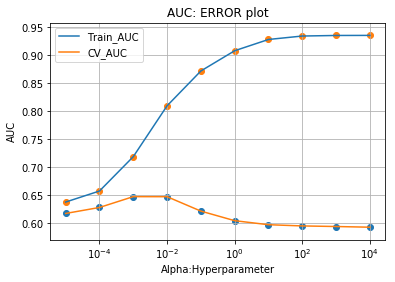

In [85]:
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

train_auc=[]
cv_auc=[]
alpha= [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
b=[]
for i in tqdm(alpha):
    mb=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    mb.fit(X_tr,y_train)
    
    y_train_pred=batch_predict(mb,X_tr)
    y_cv_pred=batch_predict(mb,X_cr)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
max_auc_ind_train=train_auc.index(max(train_auc))
alpha_max_auc_train=alpha[max_auc_ind_train]

print("max auc in train data:",max(train_auc))
print("alpha value for maximum AUC:",alpha_max_auc_train)
max_auc_ind_cv=cv_auc.index(max(cv_auc))
alpha_max_auc_cv=alpha[max_auc_ind_cv]
print("max auc  in cv data:",max(cv_auc))
print("alpha value for maximum AUC:",alpha_max_auc_cv)

plt.plot(alpha,train_auc,label='Train_AUC')
plt.plot(alpha,cv_auc,label='CV_AUC')
plt.scatter(alpha,cv_auc)
plt.scatter(alpha,train_auc)
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xscale.html
plt.xscale('log')
plt.title("AUC: ERROR plot")
plt.ylabel('AUC')
plt.xlabel('Alpha:Hyperparameter')
plt.legend()
plt.grid(1)


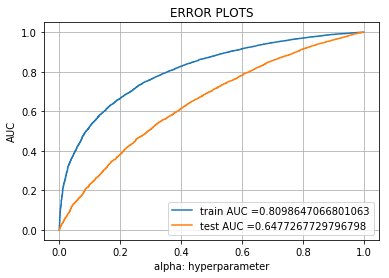

In [86]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

nb = LogisticRegression(C=0.01,class_weight='balanced',penalty='l2')
nb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict_proba(X_tr)[:,1]    
y_test_pred = nb.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr )))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [87]:
#we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba,threshold,fpr,tpr):
    t=threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high

    print("the maximum value of tpr*(1-fpr)",max(tpr*(1-fpr)))
    print("Threshold:",np.round(t,3))
    prediction=[]
    for i in proba:
        if i>=t:
            prediction.append(1)
        else:
            prediction.append(0)
    
    return prediction

the maximum value of tpr*(1-fpr) 0.5407646852843344
Threshold: 0.491


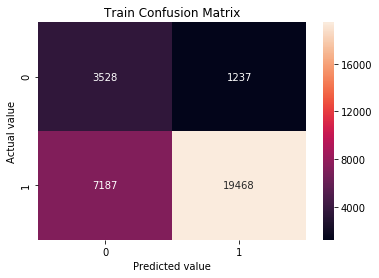

In [88]:
import seaborn as sns
#https://stackoverflow.com/a/33158941/10967428
con_tr=confusion_matrix(y_train,predict(y_train_pred,tr_thresholds,train_fpr,train_tpr))

sns.heatmap(con_tr,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Train Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

the maximum value of tpr*(1-fpr) 0.3690463321220917
Threshold: 0.478


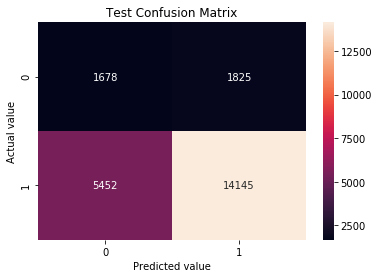

In [89]:
#https://stackoverflow.com/a/33158941/10967428
con_te=confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

sns.heatmap(con_te,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Test Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

### 2.4.2 Applying Logistic regression on TFIDF,<font color='red'> SET 2</font>

In [90]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_subcat_ohe,
               X_train_cat_ohe,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm,
               X_train_text_tfidf,X_train_title_tfidf)).tocsr()

X_cr = hstack((X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_subcat_ohe,
               X_cv_cat_ohe,X_cv_price_norm,X_cv_teacher_number_of_previously_posted_projects_norm,
               X_cv_text_tfidf,X_cv_title_tfidf)).tocsr()

X_te = hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_subcat_ohe,
               X_test_cat_ohe,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm,
               X_test_text_tfidf,X_test_title_tfidf)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(31420, 11759) (31420,)
(15477, 11759) (15477,)
(23100, 11759) (23100,)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]


max auc in train data: 0.8406841293170694
alpha value for maximum AUC: 1e-05
max auc  in cv data: 0.6650090488384159
alpha value for maximum AUC: 0.1


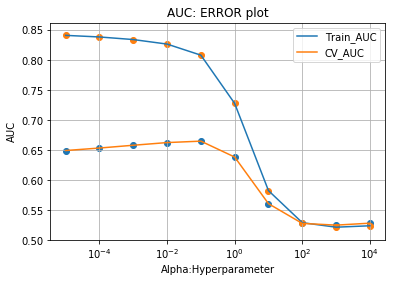

In [91]:
import matplotlib.pyplot as plt 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

train_auc=[]
cv_auc=[]
alpha= [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
b=[]
for i in tqdm(alpha):
    mb=MultinomialNB(alpha=i)
    mb.fit(X_tr,y_train)
    
    y_train_pred=batch_predict(mb,X_tr)
    y_cv_pred=batch_predict(mb,X_cr)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
max_auc_ind_train=train_auc.index(max(train_auc))
alpha_max_auc_train=alpha[max_auc_ind_train]

print("max auc in train data:",max(train_auc))
print("alpha value for maximum AUC:",alpha_max_auc_train)
max_auc_ind_cv=cv_auc.index(max(cv_auc))
alpha_max_auc_cv=alpha[max_auc_ind_cv]
print("max auc  in cv data:",max(cv_auc))
print("alpha value for maximum AUC:",alpha_max_auc_cv)

plt.plot(alpha,train_auc,label='Train_AUC')
plt.plot(alpha,cv_auc,label='CV_AUC')
plt.scatter(alpha,cv_auc)
plt.scatter(alpha,train_auc)
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xscale.html
plt.xscale('log')
plt.title("AUC: ERROR plot")
plt.ylabel('AUC')
plt.xlabel('Alpha:Hyperparameter')
plt.legend()
plt.grid(1)


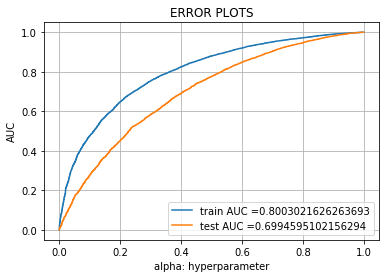

In [92]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

nb = LogisticRegression(C=0.1,class_weight='balanced',penalty='l2')
nb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict_proba(X_tr)[:,1]    
y_test_pred = nb.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr )))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.5293357291873956
Threshold: 0.487


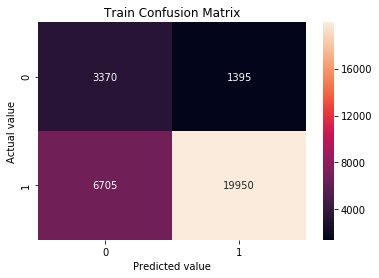

In [93]:
import seaborn as sns
#https://stackoverflow.com/a/33158941/10967428
con_tr=confusion_matrix(y_train,predict(y_train_pred,tr_thresholds,train_fpr,train_tpr))

sns.heatmap(con_tr,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Train Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

the maximum value of tpr*(1-fpr) 0.41824799396681267
Threshold: 0.497


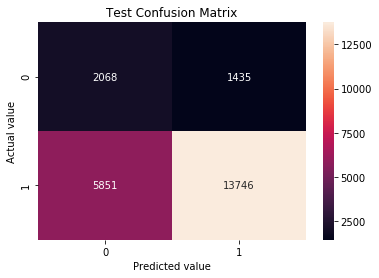

In [94]:
import seaborn as sns
#https://stackoverflow.com/a/33158941/10967428
con_te=confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

sns.heatmap(con_te,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Test Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

### 2.4.2 Applying Logistic regression on avgw2v,<font color='red'> SET 3</font>

In [95]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_subcat_ohe,
               X_train_cat_ohe,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm,
               X_train_text_avgw2v,X_train_title_avgw2v)).tocsr()

X_cr = hstack((X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_subcat_ohe,
               X_cv_cat_ohe,X_cv_price_norm,X_cv_teacher_number_of_previously_posted_projects_norm,
               X_cv_text_avgw2v,X_cv_title_avgw2v)).tocsr()

X_te = hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_subcat_ohe,
               X_test_cat_ohe,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm,
               X_test_text_avgw2v,X_test_title_avgw2v)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(31420, 201) (31420,)
(15477, 201) (15477,)
(23100, 201) (23100,)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:40<00:00, 16.17s/it]


max auc in train data: 0.6981899964235401
alpha value for maximum AUC: 100000
max auc  in cv data: 0.6926902519493862
alpha value for maximum AUC: 100000


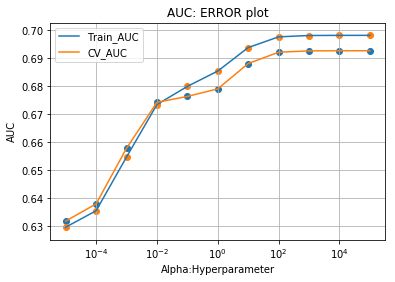

In [96]:
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

train_auc=[]
cv_auc=[]
alpha= [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 10**5]
b=[]
for i in tqdm(alpha):
    mb=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    mb.fit(X_tr,y_train)
    
    y_train_pred=batch_predict(mb,X_tr)
    y_cv_pred=batch_predict(mb,X_cr)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
max_auc_ind_train=train_auc.index(max(train_auc))
alpha_max_auc_train=alpha[max_auc_ind_train]

print("max auc in train data:",max(train_auc))
print("alpha value for maximum AUC:",alpha_max_auc_train)
max_auc_ind_cv=cv_auc.index(max(cv_auc))
alpha_max_auc_cv=alpha[max_auc_ind_cv]
print("max auc  in cv data:",max(cv_auc))
print("alpha value for maximum AUC:",alpha_max_auc_cv)

plt.plot(alpha,train_auc,label='Train_AUC')
plt.plot(alpha,cv_auc,label='CV_AUC')
plt.scatter(alpha,cv_auc)
plt.scatter(alpha,train_auc)
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xscale.html
plt.xscale('log')
plt.title("AUC: ERROR plot")
plt.ylabel('AUC')
plt.xlabel('Alpha:Hyperparameter')
plt.legend()
plt.grid(1)

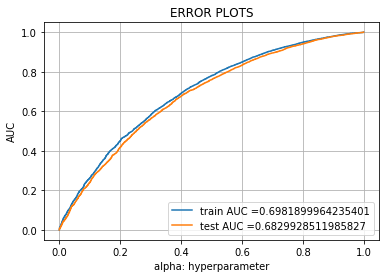

In [97]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

nb = LogisticRegression(C=10**5,class_weight='balanced',penalty='l2')
nb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict_proba(X_tr)[:,1]    
y_test_pred = nb.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr )))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.41654622638222694
Threshold: 0.498


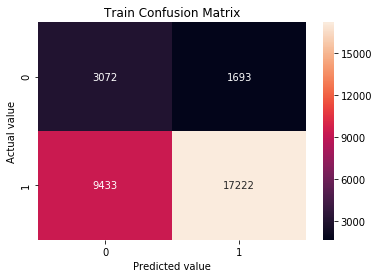

In [98]:
import seaborn as sns
#https://stackoverflow.com/a/33158941/10967428
con_tr=confusion_matrix(y_train,predict(y_train_pred,tr_thresholds,train_fpr,train_tpr))

sns.heatmap(con_tr,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Train Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

the maximum value of tpr*(1-fpr) 0.4072480114617857
Threshold: 0.537


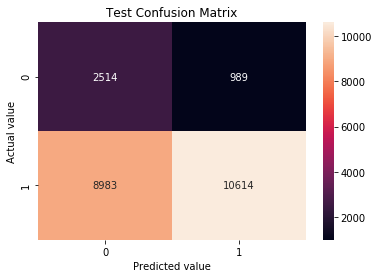

In [99]:
import seaborn as sns
#https://stackoverflow.com/a/33158941/10967428
con_te=confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

sns.heatmap(con_te,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Test Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

### 2.4.2 Applying Logistic regression on TFIDF avgw2v<font color='red'> SET 4</font>

In [100]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_subcat_ohe,
               X_train_cat_ohe,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm,
               X_train_text_tfidf_w2v,X_train_title_tfidf_w2v)).tocsr()

X_cr = hstack((X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_subcat_ohe,
               X_cv_cat_ohe,X_cv_price_norm,X_cv_teacher_number_of_previously_posted_projects_norm,
               X_cv_text_tfidf_w2v,X_cv_title_tfidf_w2v)).tocsr()

X_te = hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_subcat_ohe,
               X_test_cat_ohe,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm,
               X_test_text_tfidf_w2v,X_test_title_tfidf_w2v)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(31420, 201) (31420,)
(15477, 201) (15477,)
(23100, 201) (23100,)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:51<00:00, 18.11s/it]


max auc in train data: 0.7027282463359986
alpha value for maximum AUC: 100000
max auc  in cv data: 0.6955988604661654
alpha value for maximum AUC: 100000


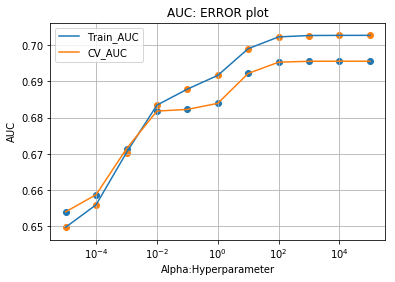

In [101]:
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

train_auc=[]
cv_auc=[]
alpha= [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 10**5]
b=[]
for i in tqdm(alpha):
    mb=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    mb.fit(X_tr,y_train)
    
    y_train_pred=batch_predict(mb,X_tr)
    y_cv_pred=batch_predict(mb,X_cr)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
max_auc_ind_train=train_auc.index(max(train_auc))
alpha_max_auc_train=alpha[max_auc_ind_train]

print("max auc in train data:",max(train_auc))
print("alpha value for maximum AUC:",alpha_max_auc_train)
max_auc_ind_cv=cv_auc.index(max(cv_auc))
alpha_max_auc_cv=alpha[max_auc_ind_cv]
print("max auc  in cv data:",max(cv_auc))
print("alpha value for maximum AUC:",alpha_max_auc_cv)

plt.plot(alpha,train_auc,label='Train_AUC')
plt.plot(alpha,cv_auc,label='CV_AUC')
plt.scatter(alpha,cv_auc)
plt.scatter(alpha,train_auc)
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xscale.html
plt.xscale('log')
plt.title("AUC: ERROR plot")
plt.ylabel('AUC')
plt.xlabel('Alpha:Hyperparameter')
plt.legend()
plt.grid(1)

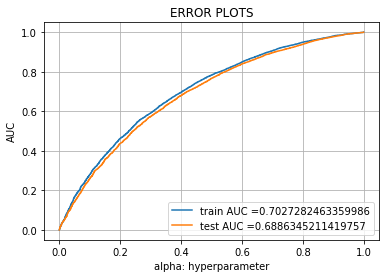

In [102]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

nb = LogisticRegression(C=10**5,class_weight='balanced',penalty='l2')
nb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict_proba(X_tr)[:,1]    
y_test_pred = nb.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr )))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.4219338589174212
Threshold: 0.485


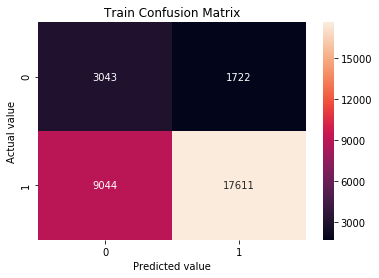

In [103]:
import seaborn as sns
#https://stackoverflow.com/a/33158941/10967428
con_tr=confusion_matrix(y_train,predict(y_train_pred,tr_thresholds,train_fpr,train_tpr))

sns.heatmap(con_tr,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Train Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

the maximum value of tpr*(1-fpr) 0.4096617059265175
Threshold: 0.525


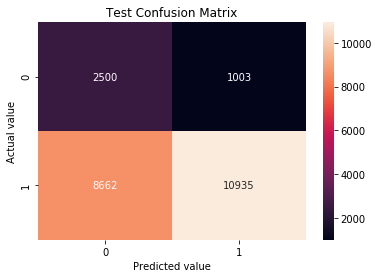

In [104]:
import seaborn as sns
#https://stackoverflow.com/a/33158941/10967428
con_te=confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

sns.heatmap(con_te,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Test Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

###  Applying Logistic regression on<font color='red'> SET 5</font>

In [105]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_subcat_ohe,
               X_train_cat_ohe,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm,
               X_train_quan_norm, X_train_now_title_norm, X_train_now_text_norm,
               X_train_pos_norm, X_train_neg_norm, X_train_neu_norm,
               X_train_com_norm)).tocsr()

X_cr = hstack((X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_subcat_ohe,
               X_cv_cat_ohe,X_cv_price_norm,X_cv_teacher_number_of_previously_posted_projects_norm,
               X_cv_quan_norm,X_cv_now_title_norm, X_cv_now_text_norm,
               X_cv_pos_norm, X_cv_neg_norm, X_cv_neu_norm,
               X_cv_com_norm)).tocsr()

X_te = hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_subcat_ohe,
               X_test_cat_ohe,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm,
               X_test_quan_norm,X_test_now_title_norm, X_test_now_text_norm,
               X_test_pos_norm, X_test_neg_norm, X_test_neu_norm,
               X_test_com_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(31420, 108) (31420,)
(15477, 108) (15477,)
(23100, 108) (23100,)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  7.51s/it]


max auc in train data: 0.6453449512178367
alpha value for maximum AUC: 100000
max auc  in cv data: 0.6449834842879261
alpha value for maximum AUC: 1000


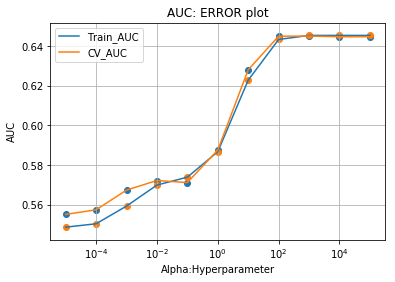

In [106]:
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

train_auc=[]
cv_auc=[]
alpha= [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 10**5]
b=[]
for i in tqdm(alpha):
    mb=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    mb.fit(X_tr,y_train)
    
    y_train_pred=batch_predict(mb,X_tr)
    y_cv_pred=batch_predict(mb,X_cr)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
max_auc_ind_train=train_auc.index(max(train_auc))
alpha_max_auc_train=alpha[max_auc_ind_train]

print("max auc in train data:",max(train_auc))
print("alpha value for maximum AUC:",alpha_max_auc_train)
max_auc_ind_cv=cv_auc.index(max(cv_auc))
alpha_max_auc_cv=alpha[max_auc_ind_cv]
print("max auc  in cv data:",max(cv_auc))
print("alpha value for maximum AUC:",alpha_max_auc_cv)

plt.plot(alpha,train_auc,label='Train_AUC')
plt.plot(alpha,cv_auc,label='CV_AUC')
plt.scatter(alpha,cv_auc)
plt.scatter(alpha,train_auc)
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xscale.html
plt.xscale('log')
plt.title("AUC: ERROR plot")
plt.ylabel('AUC')
plt.xlabel('Alpha:Hyperparameter')
plt.legend()
plt.grid(1)

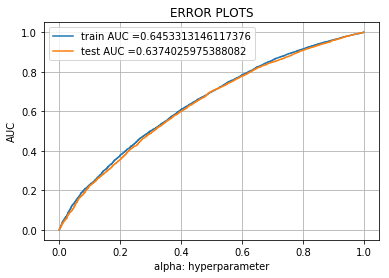

In [107]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

nb = LogisticRegression(C=1000,class_weight='balanced',penalty='l2')
nb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict_proba(X_tr)[:,1]    
y_test_pred = nb.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr )))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.36571689516052047
Threshold: 0.498


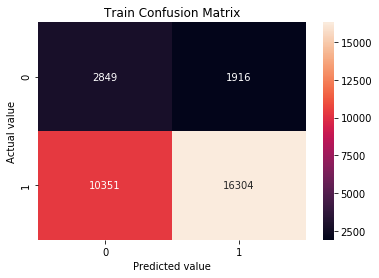

In [108]:
import seaborn as sns
#https://stackoverflow.com/a/33158941/10967428
con_tr=confusion_matrix(y_train,predict(y_train_pred,tr_thresholds,train_fpr,train_tpr))

sns.heatmap(con_tr,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Train Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

the maximum value of tpr*(1-fpr) 0.36074392587573667
Threshold: 0.531


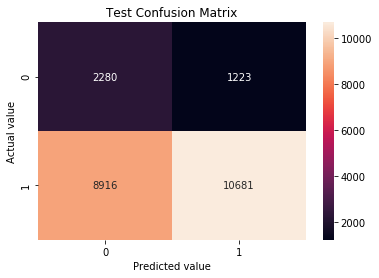

In [109]:
import seaborn as sns
#https://stackoverflow.com/a/33158941/10967428
con_te=confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

sns.heatmap(con_te,annot=True,fmt='0.00f',annot_kws={'size':10})
plt.title("Test Confusion Matrix")
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

<h1> Conclusions </h1>

In [110]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer",  "Hyper parameter", "AUC"]
x.add_row(["BOW", 1, 0.65])
x.add_row(["TFIDF", 0.1, 0.69])
x.add_row(["AVGW2V", 100000, 0.68])
x.add_row(["TFIDF W2V", 0.1, 0.68])
x.add_row(["NO TEXT", 100, 0.63])

print(x)

+------------+-----------------+------+
| Vectorizer | Hyper parameter | AUC  |
+------------+-----------------+------+
|    BOW     |        1        | 0.65 |
|   TFIDF    |       0.1       | 0.69 |
|   AVGW2V   |      100000     | 0.68 |
| TFIDF W2V  |       0.1       | 0.68 |
|  NO TEXT   |       100       | 0.63 |
+------------+-----------------+------+


<h1>Summary</h1>

1. On comparing both the results we see that TFIDF featurization works a bit well in terms precision and recall
2. Its very good compared to kNN in terms of execution time and in terms of accuracy and execution time.